# Plant 2021 with PyTorch Lightning
This notebook is a sample code using pytorch lightning.
By using pytorch lightning, you can use AMP and batch accumulation without changing the code.

The following is a notebook that uses the learned model for inference.
[Inference notebook](https://www.kaggle.com/pegasos/plant2021-pytorch-lightning-starter-inference)

In [1]:
package_paths = [
    '../input/pytorch-image-library/pytorch-image-models-master/pytorch-image-models-master',
]
import sys;

for pth in package_paths:
    sys.path.append(pth)

import timm

# Import

In [2]:
import pandas as pd
import numpy as np
import cv2
import timm
import torch
import torch.nn as nn
import albumentations as A
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from albumentations.core.composition import Compose, OneOf
from albumentations.augmentations.transforms import CLAHE, GaussNoise, ISONoise
from albumentations.pytorch import ToTensorV2

from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning import Callback
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import StratifiedKFold

In [3]:
print(f"PyTorch Lightning version: {pl.__version__}")

PyTorch Lightning version: 1.2.0


# Config

In [4]:
class CFG:
    seed = 42
    model_name = 'tf_efficientnet_b3_ns'
    pretrained = True
    img_size = 512
    num_classes = 12
    lr = 2.5e-4
    min_lr = 1e-6
    t_max = 20
    num_epochs = 20
    batch_size = 16
    accum = 1
    precision = 16
    n_fold = 5
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Load images that have been pre-resized by AnkurSingh to speed up the learning process. https://www.kaggle.com/c/plant-pathology-2021-fgvc8/discussion/227032

In [5]:
PATH = "../input/plant-pathology-2021-fgvc8/"

# TRAIN_DIR = PATH + 'train_images/'
TRAIN_DIR = "../input/resized-plant2021/img_sz_512/"
TEST_DIR = PATH + 'test_images/'

In [6]:
seed_everything(CFG.seed)

Global seed set to 42


42

In [7]:
df_all = pd.read_csv(PATH + "train.csv")
df_all.head()

,image,labels
0,800113bb65efe69e.jpg,healthy
1,8002cb321f8bfcdf.jpg,scab frog_eye_leaf_spot complex
2,80070f7fb5e2ccaa.jpg,scab
3,80077517781fb94f.jpg,scab
4,800cbf0ff87721f8.jpg,complex


## Label Encoding

In [8]:
labels = list(df_all['labels'].value_counts().keys())
labels_dict = dict(zip(labels, range(12)))
df_all = df_all.replace({"labels": labels_dict})
df_all.head()

,image,labels
0,800113bb65efe69e.jpg,1
1,8002cb321f8bfcdf.jpg,7
2,80070f7fb5e2ccaa.jpg,0
3,80077517781fb94f.jpg,0
4,800cbf0ff87721f8.jpg,4


## Split Train Data

In [9]:
sfk = StratifiedKFold(CFG.n_fold)
for train_idx, valid_idx in sfk.split(df_all['image'], df_all['labels']):
    df_train = df_all.iloc[train_idx]
    df_valid = df_all.iloc[valid_idx]
    break

In [10]:
print(f"train size: {len(df_train)}")
print(f"valid size: {len(df_valid)}")

train size: 14905
valid size: 3727


# Define Dataset

In [11]:
class PlantDataset(Dataset):
    def __init__(self, df, transform=None):
        self.image_id = df['image'].values
        self.labels = df['labels'].values
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image_id = self.image_id[idx]
        label = self.labels[idx]
        
        image_path = TRAIN_DIR + image_id
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        augmented = self.transform(image=image)
        image = augmented['image']
        return {'image':image, 'target': label}

In [12]:
def get_transform(phase: str):
    if phase == 'train':
        return Compose([
            A.RandomResizedCrop(height=CFG.img_size, width=CFG.img_size),
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(p=0.5),
            A.RandomBrightnessContrast(p=0.5),
            A.Normalize(),
            ToTensorV2(),
        ])
    else:
        return Compose([
            A.Resize(height=CFG.img_size, width=CFG.img_size),
            A.Normalize(),
            ToTensorV2(),
        ])

In [13]:
train_dataset = PlantDataset(df_train, get_transform('train'))
valid_dataset = PlantDataset(df_valid, get_transform('valid'))

train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=2)

# Define Model

In [14]:
class CustomResNet(nn.Module):
    def __init__(self, model_name='resnet18', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.model.get_classifier().in_features
        self.model.fc = nn.Linear(in_features, CFG.num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

In [15]:
class CustomEfficientNet(nn.Module):
    def __init__(self, model_name='tf_efficientNet_b0_ns', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        in_features = self.model.get_classifier().in_features
        self.model.classifier = nn.Linear(in_features, CFG.num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

In [16]:
class LitCassava(pl.LightningModule):
    def __init__(self, model):
        super(LitCassava, self).__init__()
        self.model = model
        self.metric = pl.metrics.F1(num_classes=CFG.num_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.lr = CFG.lr

    def forward(self, x, *args, **kwargs):
        return self.model(x)

    def configure_optimizers(self):
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=CFG.t_max, eta_min=CFG.min_lr)

        return {'optimizer': self.optimizer, 'lr_scheduler': self.scheduler}

    def training_step(self, batch, batch_idx):
        image = batch['image']
        target = batch['target']
        output = self.model(image)
        loss = self.criterion(output, target)
        score = self.metric(output.argmax(1), target)
        logs = {'train_loss': loss, 'train_f1': score, 'lr': self.optimizer.param_groups[0]['lr']}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss

    def validation_step(self, batch, batch_idx):
        image = batch['image']
        target = batch['target']
        output = self.model(image)
        loss = self.criterion(output, target)
        score = self.metric(output.argmax(1), target)
        logs = {'valid_loss': loss, 'valid_f1': score}
        self.log_dict(
            logs,
            on_step=False, on_epoch=True, prog_bar=True, logger=True
        )
        return loss


In [17]:
model = CustomEfficientNet(model_name=CFG.model_name, pretrained=CFG.pretrained)
lit_model = LitCassava(model)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b3_ns-9d44bf68.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b3_ns-9d44bf68.pth


In [18]:
logger = CSVLogger(save_dir='logs/', name=CFG.model_name)
logger.log_hyperparams(CFG.__dict__)
checkpoint_callback = ModelCheckpoint(monitor='valid_loss',
                                      save_top_k=1,
                                      save_last=True,
                                      save_weights_only=True,
                                      filename='{epoch:02d}-{valid_loss:.4f}-{valid_f1:.4f}',
                                      verbose=False,
                                      mode='min')

trainer = Trainer(
    max_epochs=CFG.num_epochs,
    gpus=1,
    accumulate_grad_batches=CFG.accum,
    precision=CFG.precision,
    # callbacks=[EarlyStopping(monitor='valid_loss', patience=3, mode='min')],
    checkpoint_callback=checkpoint_callback,
    logger=logger,
    weights_summary='top',
)



GPU available: True, used: True
TPU available: None, using: 0 TPU cores
Using native 16bit precision.


# Training

In [19]:
trainer.fit(lit_model, train_dataloader=train_loader, val_dataloaders=valid_loader)

/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/saving.py:401: UserWarning: Skipping '__dict__' parameter because it is not possible to safely dump to YAML.
  warn(f"Skipping '{k}' parameter because it is not possible to safely dump to YAML.")
/opt/conda/lib/python3.7/site-packages/pytorch_lightning/core/saving.py:401: UserWarning: Skipping '__weakref__' parameter because it is not possible to safely dump to YAML.
  warn(f"Skipping '{k}' parameter because it is not possible to safely dump to YAML.")

  | Name      | Type               | Params
-------------------------------------------------
0 | model     | CustomEfficientNet | 10.7 M
1 | metric    | F1                 | 0     
2 | criterion | CrossEntropyLoss   | 0     
-------------------------------------------------
10.7 M    Trainable params
0         Non-trainable params
10.7 M    Total params
42.859    Total estimated model params size (MB)


Validation sanity check: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Validating: |          | 0/? [00:00<?, ?it/s]

Saving latest checkpoint...


1

# Result

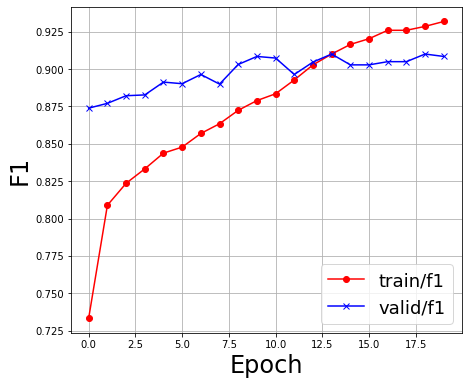

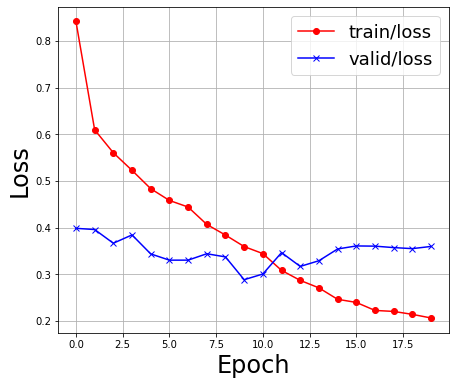

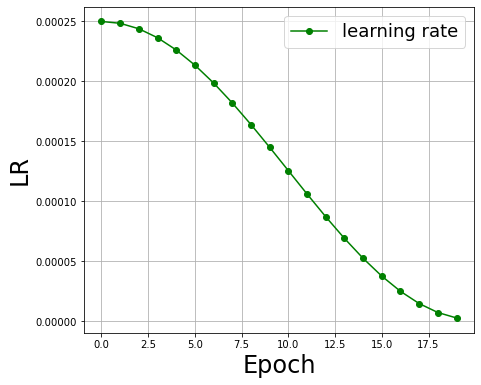

In [20]:
metrics = pd.read_csv(f'{trainer.logger.log_dir}/metrics.csv')

train_acc = metrics['train_f1'].dropna().reset_index(drop=True)
valid_acc = metrics['valid_f1'].dropna().reset_index(drop=True)
    
fig = plt.figure(figsize=(7, 6))
plt.grid(True)
plt.plot(train_acc, color="r", marker="o", label='train/f1')
plt.plot(valid_acc, color="b", marker="x", label='valid/f1')
plt.ylabel('F1', fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.legend(loc='lower right', fontsize=18)
plt.savefig(f'{trainer.logger.log_dir}/f1.png')

train_loss = metrics['train_loss'].dropna().reset_index(drop=True)
valid_loss = metrics['valid_loss'].dropna().reset_index(drop=True)

fig = plt.figure(figsize=(7, 6))
plt.grid(True)
plt.plot(train_loss, color="r", marker="o", label='train/loss')
plt.plot(valid_loss, color="b", marker="x", label='valid/loss')
plt.ylabel('Loss', fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.legend(loc='upper right', fontsize=18)
plt.savefig(f'{trainer.logger.log_dir}/loss.png')\

lr = metrics['lr'].dropna().reset_index(drop=True)

fig = plt.figure(figsize=(7, 6))
plt.grid(True)
plt.plot(lr, color="g", marker="o", label='learning rate')
plt.ylabel('LR', fontsize=24)
plt.xlabel('Epoch', fontsize=24)
plt.legend(loc='upper right', fontsize=18)
plt.savefig(f'{trainer.logger.log_dir}/lr.png')